# Spotify Track Feature Analysis 1921-2020

<p style = "font-size:20px ; line-height: 2">
By Shuki Santana-Molk
</p>

<p style = "font-size:20px ; line-height: 2">
Dataset from:<br>
    <a href="https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks" target="_blank"> https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks</a><br>
    Direct download (~33 MB):<br>
    <a href="https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks/download" target="_blank"> https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks/download</a><br>
    In order to better understand the characteristics Spotify assigns to each track, please read this<br>
        <a href="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/" target="_blank"> Audio Features Documentation</a> and
    <a href = "https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/" target="_blank">Track Features Documentation</a>.<BR>
Please notice - Not every feature is included in our database.
    </p>

### Research Questions:

<p style = "font-size:20px ; line-height: 2">
1. General overview and exceptional phenomena.<br>
2. Popularity of musical keys.<br>    
3. How different songs' characters changed over the years:<br>
$\;\;\;$- a. Length<br>
$\;\;\;$- b. Loudness (is <a href="https://en.wikipedia.org/wiki/Loudness_war" target="_blank">The Loudness War</a> a real thing?)<br>
$\;\;\;$- c. Tempo<br>
$\;\;\;$- d. Explicit (number of explicit songs per year)<br>
$\;\;\;$- e. Speechiness - explicit correlation<br>
4. What makes a song popular over different time periods.<br>
</p>

In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it

<p style = "font-size:20px ; line-height: 2">
Reading and preparing the file
</p>

In [345]:
# The file name is just data.cav, to avoid confusion,
# it's recommended to change it to 'data_1921_2020.csv', or any other more distinct name.
spt = pd.read_csv(r'data_1921_2020.csv')
spt.head(1)

spt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

<p style = "font-size:20px ; line-height: 2">
This is not a very big file (24.6 MB), but we can reduce its size anyway.<br>
We will:<br>
1. Load only needed columns:<br>
$\;\;\;\;$ As we are only interested in looking at the trends and not in particular songs or artists, we can discard the following columns: artists, id, name, and also release_date (we alreay have a year column).<br>
2. Convert numerical type columns into a smaller numerical datatype:<br>
$\;\;\;\;$- Reducing datatype of these columns: duration, explicit, key, mode, tempo, year.<br>
$\;\;\;\;$- Converting duration from miliseconds to seconds.
</p>

In [346]:
# Loading only selected columns
spt = pd.read_csv(r'data_1921_2020.csv'
                 ,usecols = [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18])
spt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   danceability      169909 non-null  float64
 2   duration_ms       169909 non-null  int64  
 3   energy            169909 non-null  float64
 4   explicit          169909 non-null  int64  
 5   instrumentalness  169909 non-null  float64
 6   key               169909 non-null  int64  
 7   liveness          169909 non-null  float64
 8   loudness          169909 non-null  float64
 9   mode              169909 non-null  int64  
 10  popularity        169909 non-null  int64  
 11  speechiness       169909 non-null  float64
 12  tempo             169909 non-null  float64
 13  valence           169909 non-null  float64
 14  year              169909 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 19.4 MB


<p style = "font-size:20px ; line-height: 2">
We dropped from 24.6 MB to 19.4 MB (20%).<br>
    Next step would be downsizing numerical columns, but first we need to check the max value for each column, in order to make sure we do not convert it into a non supporting type.<br>
</p>

In [347]:
for cl in list(spt.columns):
    print(f'Max absolute value of {cl} is {abs(spt[cl]).max()}')

Max absolute value of acousticness is 0.996
Max absolute value of danceability is 0.988
Max absolute value of duration_ms is 5403500
Max absolute value of energy is 1.0
Max absolute value of explicit is 1
Max absolute value of instrumentalness is 1.0
Max absolute value of key is 11
Max absolute value of liveness is 1.0
Max absolute value of loudness is 60.0
Max absolute value of mode is 1
Max absolute value of popularity is 100
Max absolute value of speechiness is 0.9690000000000001
Max absolute value of tempo is 244.09099999999998
Max absolute value of valence is 1.0
Max absolute value of year is 2020


In [348]:
# Based on the above information, we will read the columns with more efficient datatypes
# (Float16 precision is more than enough for our purposes)
spt = pd.read_csv(r'data_1921_2020.csv'
                 ,usecols = [0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18]
                 ,dtype = {0 : 'float16'
                           ,2 : 'float16'
                           ,4 : 'float16'
                           ,5 : 'int8'
                           ,7 : 'float16'
                           ,8 : 'int8'
                           ,9 : 'float16'
                           ,10 : 'float16'
                           ,11 : 'int8'
                           ,13 : 'float16'
                           ,15 : 'float16'
                           ,16 : 'float16'
                           ,17 : 'float16'
                           ,18 : 'int16'})

#----------------------------------------
# Convrting duration to seconds:
spt['duration_ms'] = np.round(spt['duration_ms'] /1000).astype(np.int16)
spt.rename(columns = {'duration_ms' : 'duration'}, inplace = True)

#----------------------------------------
# Converting tempo into int16
spt['tempo'] = spt['tempo'].astype(np.int16)

print('Dataframe After Size Reduction')
print()
spt.info()

Dataframe After Size Reduction

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float16
 1   danceability      169909 non-null  float16
 2   duration          169909 non-null  int16  
 3   energy            169909 non-null  float16
 4   explicit          169909 non-null  int8   
 5   instrumentalness  169909 non-null  float16
 6   key               169909 non-null  int8   
 7   liveness          169909 non-null  float16
 8   loudness          169909 non-null  float16
 9   mode              169909 non-null  int8   
 10  popularity        169909 non-null  float16
 11  speechiness       169909 non-null  float16
 12  tempo             169909 non-null  int16  
 13  valence           169909 non-null  float16
 14  year              169909 non-null  int16  
dtypes: float16(9), int16(3), int8(3)
mem

<p style = "font-size:20px ; line-height: 2">
After conducting all these downsizing, we managed to go from from 24.6 MB to 4.4 MB - less than 20% of the original size!
</p>

In [349]:
# Next step - arranging the columns in a way that makes a little more sense, instead of alphabetically
spt = spt[['year', 'duration', 'loudness', 'tempo', 'popularity', 'instrumentalness', 'speechiness', 'acousticness', 'danceability', 'energy', 'liveness', 'valence', 'explicit', 'key', 'mode']]

spt.head(1)

,year,duration,loudness,tempo,popularity,instrumentalness,speechiness,acousticness,danceability,energy,liveness,valence,explicit,key,mode
0,1928,159,-12.429688,118,0.0,0.562988,0.050598,0.995117,0.708008,0.194946,0.151001,0.778809,0,10,1


## Analysis
## 1. General overview and exceptional phenomena

In [350]:
# Firstly, a quick summary of all the main statistical attributes for each feature
spt_dscrb = spt.describe(percentiles = [0.1, 0.3, 0.5, 0.7, 0.9])
spt_dscrb

,year,duration,loudness,tempo,popularity,instrumentalness,speechiness,acousticness,danceability,energy,liveness,valence,explicit,key,mode
count,169909.000000,169909.000000,169909.000000,169909.000000,169909.0,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000
mean,1977.223231,231.404081,NaN,116.525581,NaN,0.161987,0.094055,NaN,NaN,NaN,0.206665,NaN,0.084863,5.200519,0.708556
std,25.593168,121.320810,0.000000,30.744585,0.0,0.309082,0.149780,0.000000,0.000000,0.000000,0.176758,0.000000,0.278679,3.515257,0.454429
min,1921.000000,5.000000,-60.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,1942.000000,137.000000,-18.921875,79.000000,0.0,0.000000,0.030106,0.009033,0.298096,0.130981,0.072998,0.159058,0.000000,0.000000,0.000000
30%,1961.000000,179.000000,-13.507812,97.000000,19.0,0.000002,0.036591,0.147949,0.447021,0.303955,0.104980,0.366943,0.000000,2.000000,1.000000
50%,1978.000000,209.000000,-10.476562,114.000000,33.0,0.000204,0.045013,0.491943,0.547852,0.480957,0.135010,0.543945,0.000000,5.000000,1.000000
70%,1995.000000,250.000000,-7.781250,130.000000,45.0,0.023895,0.064575,0.831055,0.641113,0.663086,0.223022,0.708008,0.000000,8.000000,1.000000
90%,2012.000000,336.000000,-5.015625,161.000000,60.0,0.831055,0.192017,0.982910,0.759766,0.867188,0.407959,0.887207,0.000000,10.000000,1.000000
max,2020.000000,5404.000000,3.855469,244.000000,100.0,1.000000,0.969238,0.996094,0.987793,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000


<p style = "font-size:20px ; line-height: 2">
While some statistical analysis doesn't make too much sense over some of the features (i.e. average year or average key), other do.<br>
For example, the ‘mode’ feature which represents if a song is in a minor or a major key - only has two options (0 for minor or 1 for major). By calculating its average (0.708556) we actually get the percentage of major songs (and by deduction - the percentage of minor songs) of the total number of songs. In this case, about 7 out of 10 songs are in a major key.<br>
Another example - most songs are not very instrumental - by the 70% percentile we still have only 0.0239 instrumentalness rate, only when we reach the 90% percentile we get 0.831 instrumentalness rate.
</p>

In [351]:
# Next, we would examine the correlation between the different features.
# At first, let's display the values as a simple correlation table.
spt_corr = spt.corr()
spt_corr

,year,duration,loudness,tempo,popularity,instrumentalness,speechiness,acousticness,danceability,energy,liveness,valence,explicit,key,mode
year,1.000000,0.076291,0.490118,0.139305,0.880724,-0.291571,-0.120938,-0.624559,0.203429,0.532420,-0.055838,-0.029303,0.245227,0.012503,-0.033084
duration,0.076291,1.000000,-0.014683,-0.028805,0.063290,0.084810,-0.058442,-0.079320,-0.134506,0.036404,0.034282,-0.198761,-0.043807,-0.003116,-0.046983
loudness,0.490118,-0.014683,1.000000,0.212079,0.466546,-0.417032,-0.105797,-0.567079,0.294168,0.782981,0.052986,0.308419,0.152694,0.021922,-0.013146
tempo,0.139305,-0.028805,0.212079,1.000000,0.136296,-0.107899,-0.010098,-0.205998,-0.004075,0.250840,0.008062,0.171137,0.012295,0.003205,0.014331
popularity,0.880724,0.063290,0.466546,0.136296,1.000000,-0.299829,-0.135707,-0.593354,0.221075,0.497488,-0.075292,0.009328,0.214044,0.010675,-0.032854
instrumentalness,-0.291571,0.084810,-0.417032,-0.107899,-0.299829,1.000000,-0.115735,0.335841,-0.281429,-0.287691,-0.047396,-0.193929,-0.138291,-0.014267,-0.035050
speechiness,-0.120938,-0.058442,-0.105797,-0.010098,-0.135707,-0.115735,1.000000,-0.056075,0.225305,-0.045225,0.147667,0.056386,0.413075,0.015224,-0.057493
acousticness,-0.624559,-0.079320,-0.567079,-0.205998,-0.593354,0.335841,-0.056075,1.000000,-0.265948,-0.750286,-0.023872,-0.185537,-0.253689,-0.021685,0.046471
danceability,0.203429,-0.134506,0.294168,-0.004075,0.221075,-0.281429,0.225305,-0.265948,1.000000,0.220568,-0.105529,0.560242,0.241890,0.022600,-0.045306
energy,0.532420,0.036404,0.782981,0.250840,0.497488,-0.287691,-0.045225,-0.750286,0.220568,1.000000,0.126296,0.350085,0.142679,0.029983,-0.038355


In [352]:
# spt_dscrb.to_excel(r'spt_dscrb.xlsx')

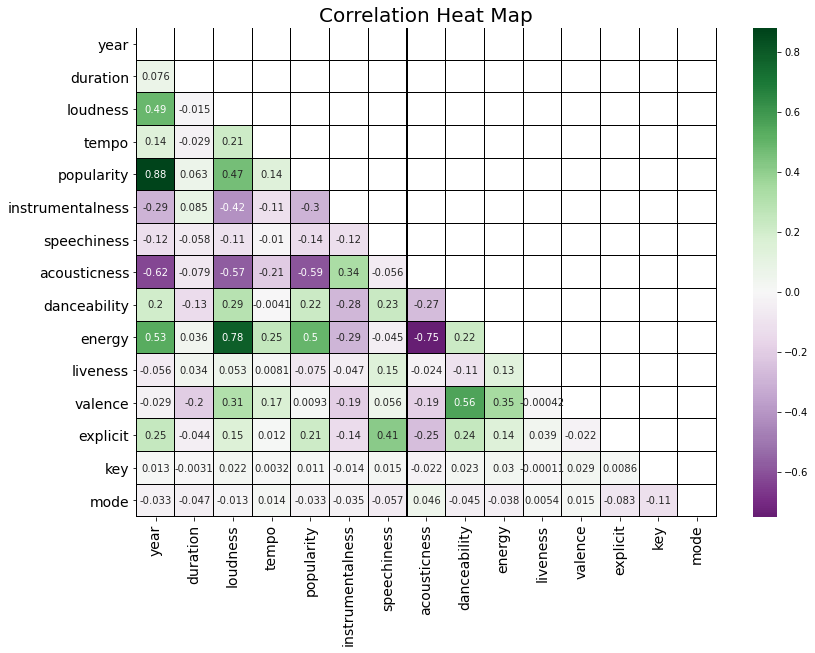

In [353]:
# However, a more comfortable way would be displaying it as a Heat Map
plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize = (13,9))

mask = np.zeros_like(spt.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

spt_hm = sns.heatmap(spt.corr()
                    ,mask = mask
                    ,cmap = 'PRGn'
                    ,annot = True
                    ,cbar = True
                    ,center = 0
                    ,linewidth = 0.05
                    ,linecolor = 'black')

spt_hm.set_xticklabels(spt_hm.get_xmajorticklabels(), fontsize = 14, rotation = 90)
spt_hm.set_yticklabels(spt_hm.get_xmajorticklabels(), fontsize = 14)

plt.title('Correlation Heat Map', fontdict = {'fontsize' : 20})
plt.show()

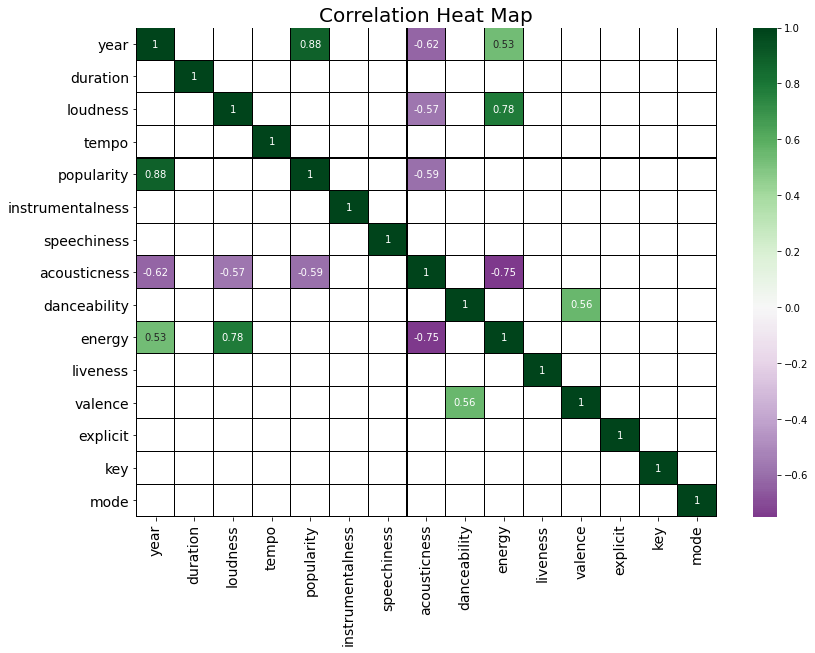

In [354]:
# But wouldn't it be better though, to focus only on correlations stonger than 0.5?
plt.figure(figsize = (13,9))

mask_spt_corr = spt_corr[abs(spt_corr) > 0.5]

spt_hm = sns.heatmap(mask_spt_corr
                    ,cmap = 'PRGn'
                    ,annot = True
                    ,cbar = True
                    ,center = 0
                    ,linewidth = 0.07
                    ,linecolor = 'black')

spt_hm.set_xticklabels(spt_hm.get_xmajorticklabels(), fontsize = 14, rotation = 90)
spt_hm.set_yticklabels(spt_hm.get_xmajorticklabels(), fontsize = 14)

plt.title('Correlation Heat Map', fontdict = {'fontsize' : 20})
plt.show()

<p style = "font-size:20px ; line-height: 2">
The stronger the correlation is between 2 features, the darker the color gets.<br>
We can see most correlations are quite light, meaning - weak correlations.<br>
Let us see only correlations higher than 0.5.<br>
Notice that correlation can be positive (The higher one feature goes, so does the other), or negative (When one feature is higher, the other is lower and vice versa). Thus, a correlation stronger than 0.5 is also a correlation lower than (-0.5).
</p>

In [355]:
# Let's get all the correlations with higher than 0.5 
# Creating a DF containing only absolute values higher than 0.5
mask_05_spt_corr = spt_corr[abs(spt_corr) > 0.5]

# Inserting the values into a dictionary
over_05_corr = {}

for row in mask_05_spt_corr.index:
    for col in mask_05_spt_corr.columns:
        if (abs(mask_05_spt_corr[row][col]) >=0.5) & (mask_05_spt_corr[row][col] != 1):
            over_05_corr[(row, col)] =  mask_05_spt_corr[row][col]
            
over_05_corr

{('year', 'popularity'): 0.8807241644750167,
 ('year', 'acousticness'): -0.6245588720553954,
 ('year', 'energy'): 0.5324195814270654,
 ('loudness', 'acousticness'): -0.5670788590244086,
 ('loudness', 'energy'): 0.7829806054198414,
 ('popularity', 'year'): 0.8807241644750167,
 ('popularity', 'acousticness'): -0.5933536569832886,
 ('acousticness', 'year'): -0.6245588720553954,
 ('acousticness', 'loudness'): -0.5670788590244086,
 ('acousticness', 'popularity'): -0.5933536569832886,
 ('acousticness', 'energy'): -0.7502863679586607,
 ('danceability', 'valence'): 0.5602416447727726,
 ('energy', 'year'): 0.5324195814270654,
 ('energy', 'loudness'): 0.7829806054198414,
 ('energy', 'acousticness'): -0.7502863679586607,
 ('valence', 'danceability'): 0.5602416447727726}

In [356]:
# Removing duplicates.
swap = lambda k: (k[1], k[0])

for k in over_05_corr.copy():
    over_05_corr[swap(k)] = over_05_corr.pop(k)

over_05_corr

{('year', 'popularity'): 0.8807241644750167,
 ('year', 'acousticness'): -0.6245588720553954,
 ('loudness', 'acousticness'): -0.5670788590244086,
 ('popularity', 'acousticness'): -0.5933536569832886,
 ('year', 'energy'): 0.5324195814270654,
 ('loudness', 'energy'): 0.7829806054198414,
 ('acousticness', 'energy'): -0.7502863679586607,
 ('danceability', 'valence'): 0.5602416447727726}

In [357]:
# Sorting the correlations, strongest first.
over_05_corr = {k: v for k, v in sorted(over_05_corr.items(), key=lambda item: abs(item[1]), reverse=True)}
over_05_corr

{('year', 'popularity'): 0.8807241644750167,
 ('loudness', 'energy'): 0.7829806054198414,
 ('acousticness', 'energy'): -0.7502863679586607,
 ('year', 'acousticness'): -0.6245588720553954,
 ('popularity', 'acousticness'): -0.5933536569832886,
 ('loudness', 'acousticness'): -0.5670788590244086,
 ('danceability', 'valence'): 0.5602416447727726,
 ('year', 'energy'): 0.5324195814270654}

<p style = "font-size:20px ; line-height: 2">
We will not examine every correlation, but will analyze those above 0.6.<br>
From this list we can learn that the strongest correlation (0.88) is between 'year' and 'popularity' which makes sense:
most people would listen either to recent songs and / or songs from their youth.<br>
Less people would listen to songs from the 1920's or 1930's.<br>
In fact, let's see popularity as a function of release year:
</p>

In [358]:
year_pplrty = spt.groupby('year').agg({'popularity' : 'mean'})\
.rename(columns = {'popularity' : 'avg_popularity'})

year_pplrty.head()

,avg_popularity
year,
1921,0.351562
1922,0.138916
1923,5.726562
1924,0.603516
1925,2.707031


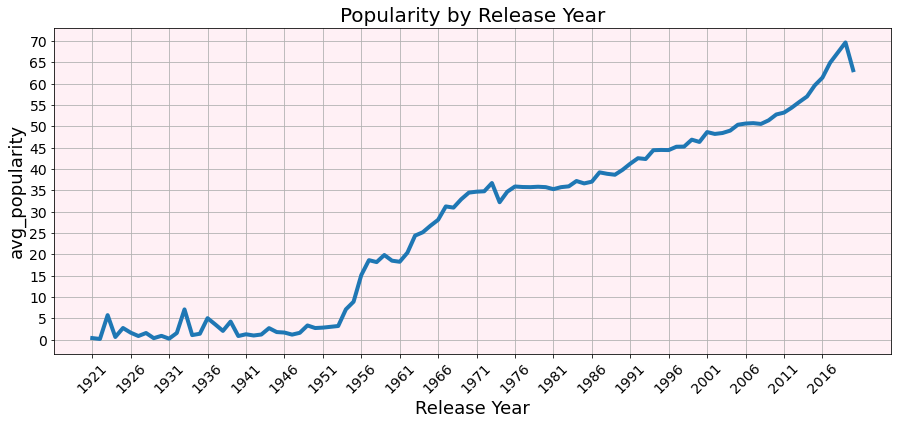

In [359]:
plt.rcParams['axes.facecolor'] = 'lavenderblush'
plt.figure(figsize = (15,6))

plt.plot(year_pplrty.index, year_pplrty['avg_popularity'], linewidth = 4)

plt.xlabel('Release Year', fontsize = 18)
plt.ylabel('avg_popularity', fontsize = 18)

plt.xticks(year_pplrty.index[::5], rotation=45, fontsize = 14 )

min_pop = int(np.round( year_pplrty['avg_popularity'].min() ))
max_pop = int(np.round( year_pplrty['avg_popularity'].max() ))
plt.yticks(range(min_pop, max_pop+1 )[::5], fontsize = 14 )

plt.title('Popularity by Release Year', fontsize = 20)
plt.grid()
plt.show()

### ---------------------------------------------------------------------------------------------------------

<p style = "font-size:20px ; line-height: 2">
The 2nd strongest correlation is between loudness and energy.<br>
This is actually a known relationship which lead to what is known as "The loudness war".<br>
Let's see a visualisaition of this correlation.<br>
</p>

In [360]:
loud_energy = spt.groupby('loudness')['energy'].mean()\
            .to_frame()\
            .rename(columns = {'energy' : 'avg_energy'})

loud_energy.head()

,avg_energy
loudness,
-60.00000,0.000000
-55.00000,0.000246
-54.37500,0.616211
-51.12500,0.137939
-51.09375,0.416992


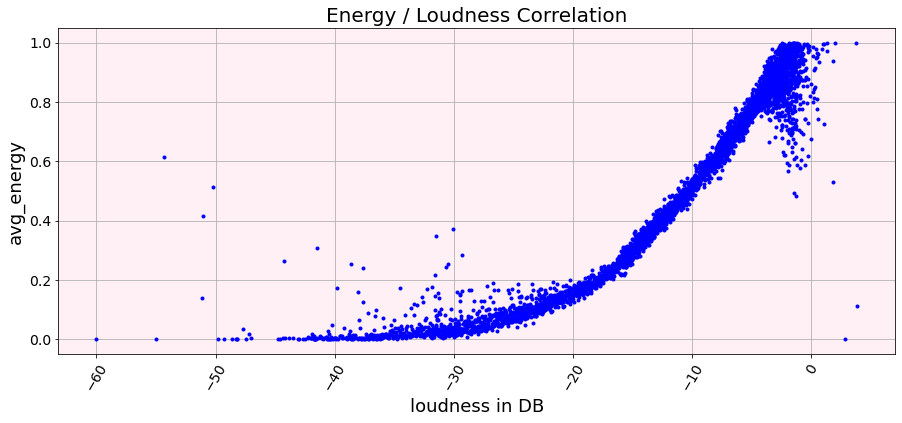

In [361]:
plt.figure(figsize = (15,6))

plt.plot(loud_energy.index, loud_energy['avg_energy'], 'k.', color = 'b')

plt.xlabel('loudness in DB', fontsize = 18)
plt.ylabel('avg_energy', fontsize = 18)

plt.xticks( rotation=60, fontsize = 14 )
plt.yticks( fontsize = 14 )

plt.title('Energy / Loudness Correlation', fontsize = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
We can see that the loudness / energy correlation is well established in our dataset.<br>
<b>However</b>, this correlation might be a result of the way spotify algorithm calculates the energy level.<br>
While DB (Loudness) is a measurable value, the energy level is a matter of debate, and as far as we know, the energy rate given to a song might be a calculated result of its loudness.
    </p>

## ---------------------------------------------------------------------------------------------------------

<p style = "font-size:20px ; line-height: 2">
The 3rd correlation is acousticness / energy.<br>
This is a negative correlation, meaning when one feature is higher, the other is lower and vice versa.
</p>

In [362]:
acst_nrg = spt.groupby('acousticness')['energy'].mean()\
.to_frame()

acst_nrg.head()

,energy
acousticness,
0.000000,0.133667
0.000001,0.798340
0.000001,0.825195
0.000001,0.919434
0.000001,0.618652


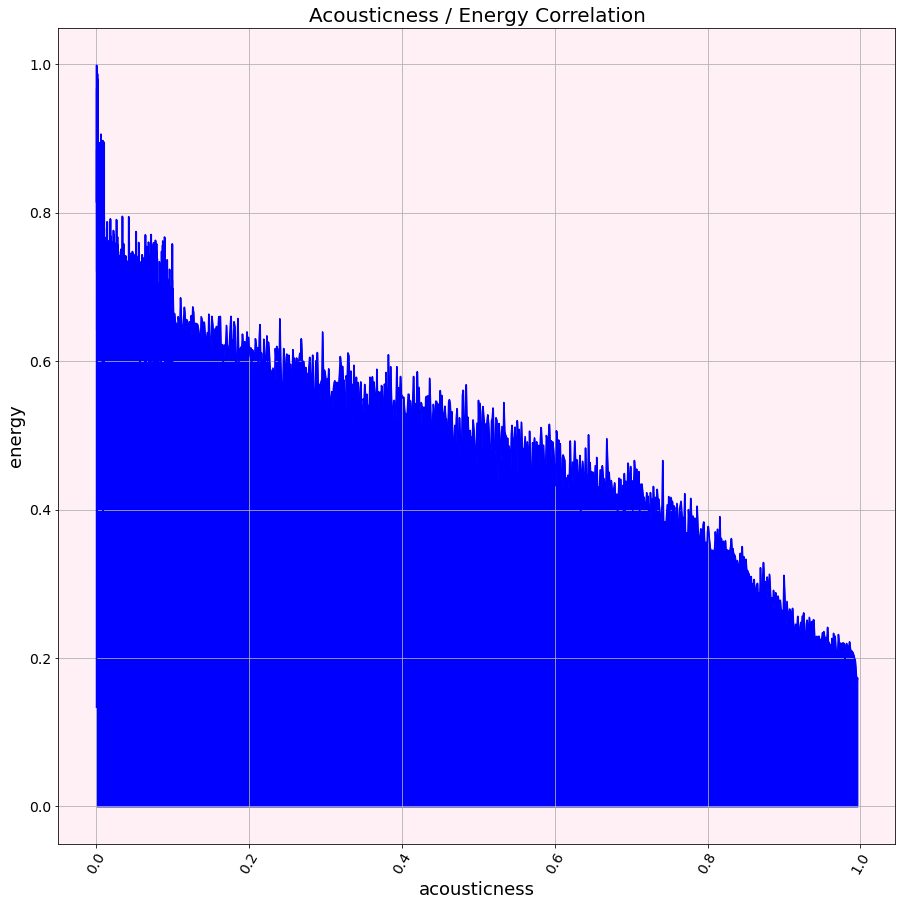

In [363]:
plt.figure(figsize = (15, 15))

plt.plot(acst_nrg.index, acst_nrg['energy'], color = 'b')
plt.fill_between(acst_nrg.index, acst_nrg['energy'], color = 'b')

plt.xlabel('acousticness', fontsize = 18)
plt.ylabel('energy', fontsize = 18)

plt.xticks( rotation=60, fontsize = 14 )
plt.yticks( fontsize = 14 )

plt.title('Acousticness / Energy Correlation', fontsize = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
This is a negative correlation, meaning when one feature is higher, the other is lower and vice versa.
We can see there’s a steady decline in the energy level as acousticness level is going up.
</p>

## ---------------------------------------------------------------------------------------------------------

<p style = "font-size:20px ; line-height: 2">
The 4th correlation, and the last we are going to analyze, is 'year' / 'acousticness', which is also a negative one, with the value of approx. (-0.62).<br>
</p>

In [364]:
year_acst = spt.groupby('year')['acousticness'].mean()\
.to_frame()

year_acst.head()

,acousticness
year,
1921,0.895996
1922,0.939453
1923,0.976562
1924,0.935547
1925,0.965332


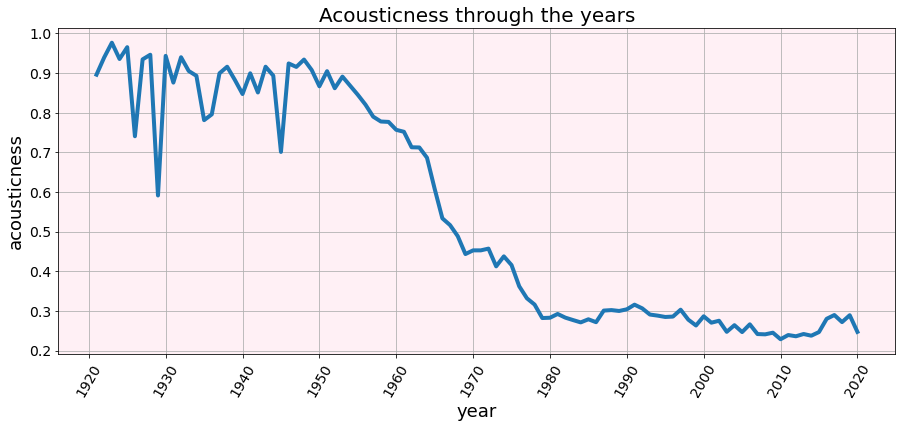

In [365]:
plt.figure(figsize = (15,6))

plt.plot(year_acst.index, year_acst['acousticness'], linewidth = 4)

plt.xlabel('year', fontsize = 18)
plt.ylabel('acousticness', fontsize = 18)

strt_yr = year_acst.index.min()
end_yr = year_acst.index.max()
plt.xticks(range(strt_yr-1, end_yr+10)[::10], rotation=60, fontsize = 14 )

plt.yticks( fontsize = 14 )

plt.title('Acousticness through the years', fontsize = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
WOW, what a drop! <br>
It is quite visible that acousticness has significally decreased during the 50's (birth of Rock'n'Roll and the (solidbody) electric guitar), 60's and 70's, and stayed more or less the same since the 80's.
</p>

## Analysis
### 2. The way different songs' characters changed over the years

### a. explicit (explicit songs per year)

<p style = "font-size:20px ; line-height: 2">
The explicit feature is a very straight forward one - it indicates whether a song contains explicit lyrics or not.<br>
Considering that the explicit values are either 0 or 1, by calculating the yearly average we get the percentage of explicit songs on each year.
 
</p>

In [366]:
# Calculating percentage of 'explicit' songs each year
xplct_prct_year = spt.groupby('year')['explicit'].mean()\
                .to_frame()\
                .rename(columns = {'explicit' : 'prcnt_of_explicit'})
xplct_prct_year['prcnt_of_explicit'] = np.round(xplct_prct_year['prcnt_of_explicit']*100).astype('int16')

xplct_prct_year.head(20)

,prcnt_of_explicit
year,
1921,5
1922,0
1923,0
1924,0
1925,0
1926,25
1927,2
1928,0
1929,47


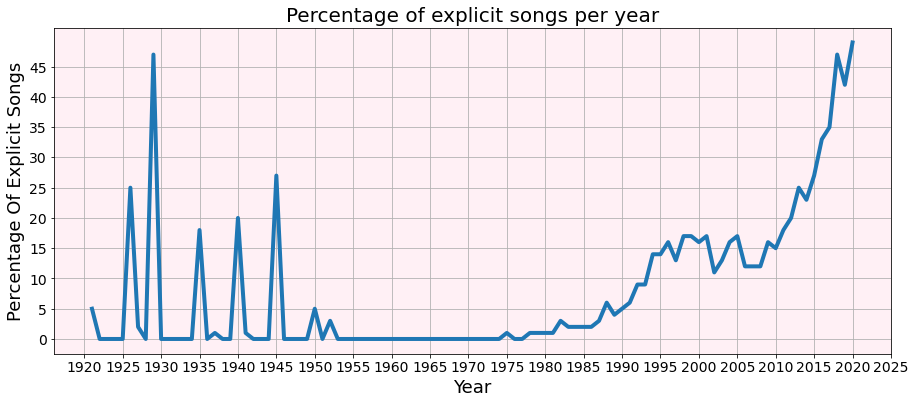

In [367]:
plt.figure(figsize = (15, 6))

plt.plot(xplct_prct_year.index, xplct_prct_year['prcnt_of_explicit'], linewidth = 4)

plt.xlabel('Year', size = 18)
plt.ylabel('Percentage Of Explicit Songs', size = 18)

min_yr = xplct_prct_year.index.min()
max_yr = xplct_prct_year.index.max()
plt.xticks(range(min_yr-1, max_yr+10)[::5] , fontsize = 14)

min_count = xplct_prct_year['prcnt_of_explicit'].min()
max_count = xplct_prct_year['prcnt_of_explicit'].max()
plt.yticks(range(min_count, max_count)[::5], fontsize = 14)

plt.title('Percentage of explicit songs per year', size = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
It is clear there's something strange about the peaks in the 20's-40's.<br>
Let's compare it with yearly songs count and also with the percentage of explicit songs for each year.
</p>

In [368]:
# Calculating number of 'explicit' songs each year
xplct_count_year = spt.groupby('year')['explicit'].sum()\
                .to_frame()\
                .rename(columns = {'explicit' : 'explicit_count'})
xplct_count_year['explicit_count'] = xplct_count_year['explicit_count'].astype('int16')
xplct_count_year.head()

,explicit_count
year,
1921,7
1922,0
1923,0
1924,0
1925,0


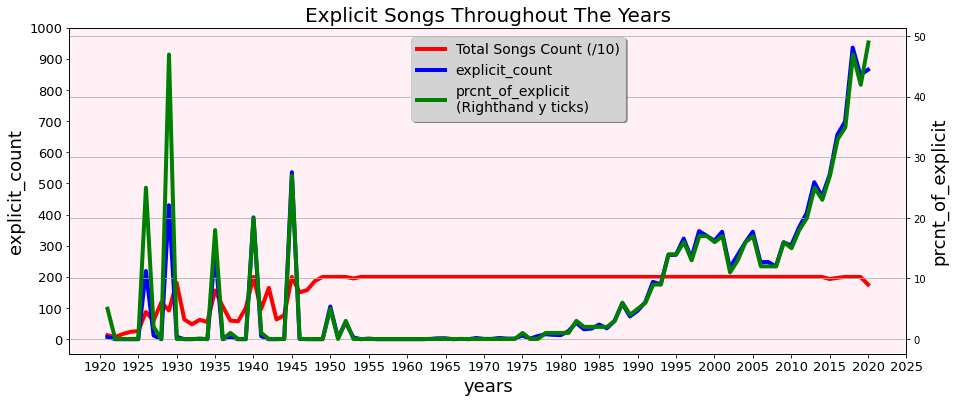

In [369]:
fig, ax1 = plt.subplots(figsize=(15,6))

ax1.set_ylabel('Total Songs Count (/10)\n\ Num Of Explicits', size = 18)
ax1.set_xlabel('years', size = 18)
ax1.plot(count_by_year.index, count_by_year['count']/10, linewidth = 4
         , label = 'Total Songs Count (/10)', color = 'red')

ax2 = ax1
ax2.set_ylabel('explicit_count', size = 18)
ax2.plot(xplct_count_year.index, xplct_count_year['explicit_count'], linewidth = 4
         , label = 'explicit_count', color = 'blue')
ax2.tick_params(axis='y')

ax3 = ax1.twinx()
ax3.set_ylabel('prcnt_of_explicit', size = 18)
ax3.plot(xplct_prct_year.index, xplct_prct_year['prcnt_of_explicit'], linewidth = 4
         , label = 'prcnt_of_explicit\n(Righthand y ticks)', color = 'green')


min_yr = count_by_year.index.min()
max_yr = count_by_year.index.max()
ax1.set_xticks(range(min_yr-1, max_yr+10)[::5])
ax1.set_xticklabels(labels = range(min_yr-1, max_yr+10)[::5], fontsize = 13)

min_count = xplct_count_year['explicit_count'].min()
max_count = xplct_count_year['explicit_count'].max()
ax1.set_yticks(range(min_count, max_count+100)[::100])
ax1.set_yticklabels(labels = range(min_count, max_count+100)[::100], fontsize = 13)


plt.title('Explicit Songs Throughout The Years', size = 20)
fig.legend(loc = (0.43,0.7), fontsize = 14, shadow = 4, facecolor='lightgrey')

ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
The correlation (where exists) between the total number of songs (in red) and the number of explicit songs (in blue) is expected, but strangely enough, the percentage (in green) is also higher in years with more songs!<br>
This calls for an investigation.<br>
<br>
One option is simply to conclude that our database is rogue.<br>
<br>
However, we can also offer another explanation:<br>
As we've already seen, some older songs were re-released over the years, either due to re-releasing an entire album or catalogue, or a compilation.<br>
For example, The beatles' "past Masters" (songs that were originally released only as singles), guardians of the galaxy soundtrack, essential jazz hits, etc.<br>
So when a record label (and that would usually be one of the "big three": Universal Music Group, Sony Music Entertainment, or Warner Music Group) make their catalogue available on spotify, they can decide not to upload an old song if they have a better re-released version of it, which is usually a better sounding one.<br>
Better sound quality <b>=></b> better chance users will add it to their personal playlist <b>=></b> more times the song is played <b>=></b> more royalties to the record label.<br>
But do all old songs have re-released versions?<br>
Naturally, re-releasing a song occures when there is a demand - successful artists, songs that were hits at their time, etc.<br>
We know that mainstream media during the 20's-50's was rather conservative (arguably, still is) and explicit songs could not become hits.<br>
That does not mean that artists didn't have explicit songs back then - just that they remained esoteric, and consequently, there was no reason for the record label to re-release them.<br>
Considering all the above, we can assume that to begin with, the percentage of explicit songs from this time period is higher than the later years (in the general Spotify database) because "clean" songs from that era would only appear under their newer release date, so the more songs from these years were sampled into our database - the higher the chance was to draw an explicit one.<br>
This is how come we get a higher 'explicit' percentage on years were the general songs count is higher.<br>
    <br>
Starting the mid 40's however, we see a steady count of ~2,000 songs per year, and indeed for 3 decades or so, very few songs containes explicit lyrics, while starting the 80's, we notice an increasement of songs with explicit lyrics.
</p>

### a. Length

In [370]:
# Calculating average length for each year
dur_by_year = spt.groupby('year')['duration'].mean()\
.to_frame()\
.rename(columns = {'duration' : 'avg_duration'})
dur_by_year.head()

,avg_duration
year,
1921,229.929688
1922,167.902778
1923,178.355030
1924,188.472574
1925,184.144487


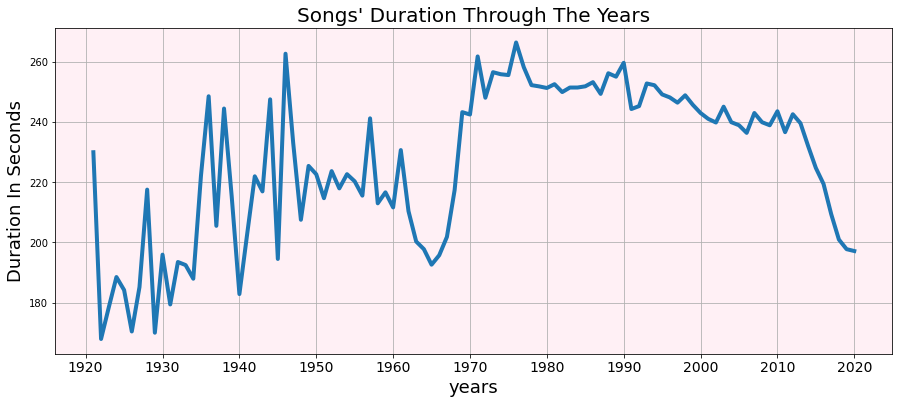

In [371]:
# Ploting of the above dataframe:
plt.figure(figsize = (15, 6))

plt.plot(dur_by_year.index, dur_by_year['avg_duration'], linewidth = 4)

plt.xlabel('years', fontsize = 18)
plt.ylabel('Duration In Seconds', fontsize = 18)

min_yr = dur_by_year.index.min()
max_yr = dur_by_year.index.max()
plt.xticks(range(min_yr-1, max_yr+10)[::10] , fontsize = 14)

plt.title("Songs' Duration Through The Years", fontsize = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
We can see that during the last part of the 60's and the beginning of the 70's there has been a leap in songs' duration from ~200 seconds (the classic 3:20 length) to ~260 seconds, which is about 1 minute (or 30%) of an increase!<br>
However, as our dataset is not the complete Spotify database, but only a sample of it - it would be wise to see how many songs from each year are in the dataset.
</p>

In [372]:
# Calculating how many songs from each year are in the database
count_by_year = spt.groupby('year')['duration'].count()\
                .to_frame()\
                .rename(columns = {'duration' : 'count'})
count_by_year.head()

,count
year,
1921,128
1922,72
1923,169
1924,237
1925,263


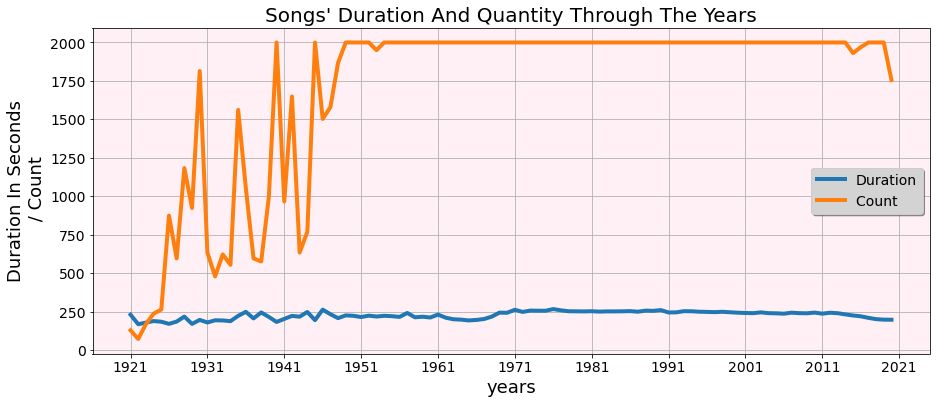

In [373]:
plt.figure(figsize = (15,6))

plt.plot(dur_by_year.index, dur_by_year['avg_duration'], linewidth = 4, label = 'Duration')
plt.plot(count_by_year.index, count_by_year['count'], linewidth = 4, label = 'Count ')

plt.xlabel('years', fontsize = 18)
plt.ylabel('Duration In Seconds\n / Count', fontsize = 18)

plt.xticks(range(count_by_year.index.min(),count_by_year.index.max()+10)[::10] , fontsize = 14)
plt.yticks(fontsize = 14)

plt.title("Songs' Duration And Quantity Through The Years", fontsize = 20)
plt.legend(loc = 'best', prop = {'size': 14}, shadow = 4, facecolor='lightgrey')
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
Obviously, the two scales are too far apart from each other.<br>
In this case, the exact number is not as important as seeing the trend, so we will "bring down" the count plot by dividing it by 10 instead of adding a 2nd ‘y’ ticks axis.
</p>

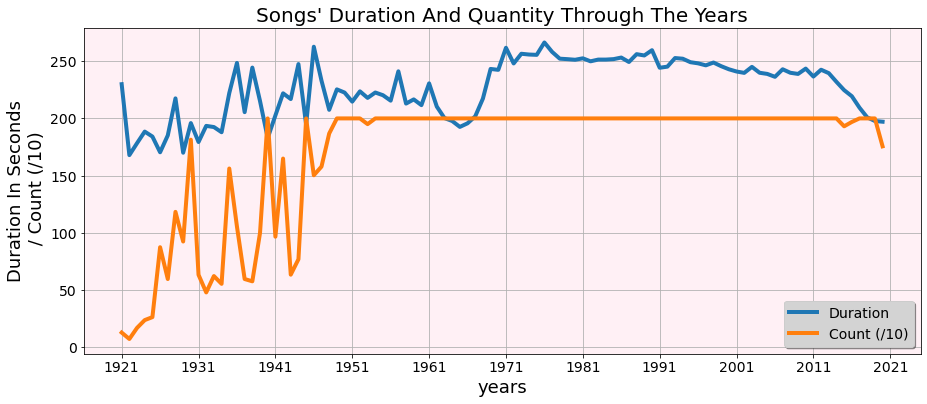

In [374]:
plt.figure(figsize = (15,6))

plt.plot(dur_by_year.index, dur_by_year['avg_duration'], linewidth = 4, label = 'Duration')
plt.plot(count_by_year.index, count_by_year['count']/10, linewidth = 4, label = 'Count (/10)')

plt.xlabel('years', fontsize = 18)
plt.ylabel('Duration In Seconds\n / Count (/10)', fontsize = 18)

plt.xticks(range(count_by_year.index.min(),count_by_year.index.max()+10)[::10] , fontsize = 14)
plt.yticks(fontsize = 14)

plt.title("Songs' Duration And Quantity Through The Years", fontsize = 20)
plt.grid()
plt.legend(loc = 4, prop = {'size': 14}, shadow = 4, facecolor='lightgrey')
plt.show()

<p style = "font-size:20px ; line-height: 2">
This looks ok.<br>
Although song count is bumpy during the 20's-50's, from the beginning of the 50's onwards we have a steady count of roughly 2,000 songs per year, so it's clear the leap we spotted in the 60's-70's is not a matter of uneven count.<br>
</p>

### b. Loudness (is "The Loudness War" a real thing?)

In [375]:
# Calculating average loudness for each year
loud_by_year = spt.groupby('year')['loudness'].mean()\
.to_frame()\
.rename(columns = {'loudness' : 'avg_loudness'})
loud_by_year.head()

,avg_loudness
year,
1921,-17.093750
1922,-19.187500
1923,-14.375000
1924,-14.203125
1925,-14.515625


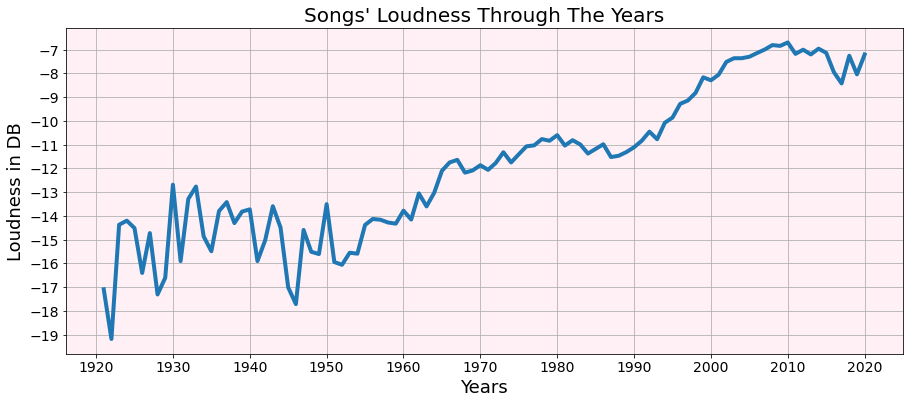

In [376]:
# Ploting of the above dataframe:
plt.figure(figsize = (15,6))

plt.plot(loud_by_year.index, loud_by_year['avg_loudness'], linewidth = 4)

min_yr = loud_by_year.index.min()
max_yr = loud_by_year.index.max()
plt.xticks(range(min_yr-1, max_yr+10)[::10] , fontsize = 14)

min_ldns = int( np.round( loud_by_year['avg_loudness'].min() ) )
max_ldns = int( np.round( loud_by_year['avg_loudness'].max() ) )
y_tx = range(min_ldns, max_ldns+1)
plt.yticks(y_tx, fontsize = 14)

plt.title("Songs' Loudness Through The Years", fontsize = 20)
plt.xlabel('Years', fontsize = 18)
plt.ylabel('Loudness in DB', fontsize = 18)

plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
So yes, loudness does increase over the years and the loudness war is indeed raging on.<br>
One more observation we can make, is that the line is bumpy until we get to the mid-50's, so we can assume the unevenness in data for these years affects our result in this case.
</p>

### c. tempo

In [377]:
# Calculating average tempo for each year
bpm_by_year = spt.groupby('year')['tempo'].mean()\
.to_frame()\
.rename(columns = {'tempo' : 'avg_tempo'})
bpm_by_year.head()

,avg_tempo
year,
1921,99.960938
1922,100.930556
1923,111.970414
1924,120.194093
1925,115.216730


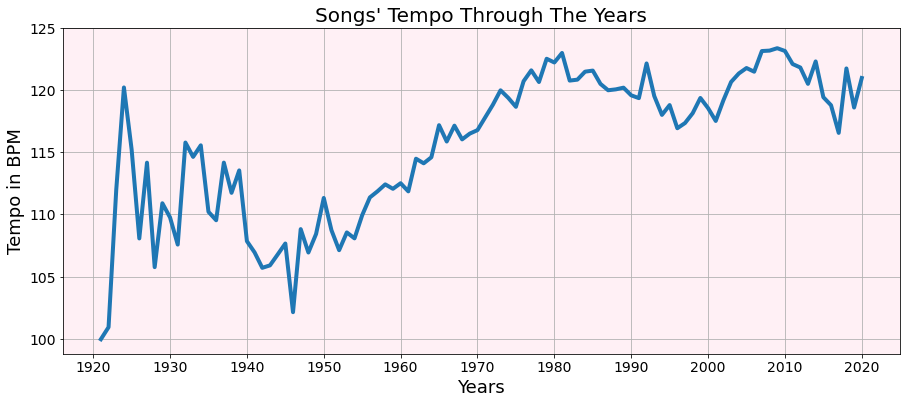

In [378]:
# Ploting of the above dataframe:
plt.figure(figsize = (15, 6))

plt.plot(bpm_by_year.index, bpm_by_year['avg_tempo'], linewidth = 4)

min_yr = loud_by_year.index.min()
max_yr = loud_by_year.index.max()
plt.xticks(range(min_yr-1, max_yr+10)[::10] , fontsize = 14)

min_bpm = int( np.round( bpm_by_year['avg_tempo'].min() ) )
max_bpm = int( np.round( bpm_by_year['avg_tempo'].max() ) )
y_tx = range(min_bpm, max_bpm+5)
plt.yticks(y_tx[::5], fontsize = 14)

plt.xlabel('Years', fontsize = 18)
plt.ylabel('Tempo in BPM', fontsize = 18)

plt.title("Songs' Tempo Through The Years", fontsize = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
Indeed we can see that songs are getting faster as years go by.<br>
But what about tempo of popular songs?<br>
We've already seen there is no noticeable correlation between popularity and tempo (0.14). Could that mean that if we examine tempo of only popular songs - we will see a relatively narrow range of BPM through the years, or maybe even prescribe an “acceptable” range for tempo of a popular song?
<br>
<br>
For this, we need to decide what a popular song is.<br>
Firstly, we want to decide what is a popoular song:
</p>

In [379]:
# Calculating distribution of popularity (how many songs have popularity of value 0, 1, 2...100)
pplr_dist = spt.groupby('popularity')['popularity'].count()\
            .to_frame()\
            .rename(columns = {'popularity' : 'count'})
pplr_dist.head()

,count
popularity,
0.0,27357
1.0,2254
2.0,1449
3.0,1200
4.0,1074


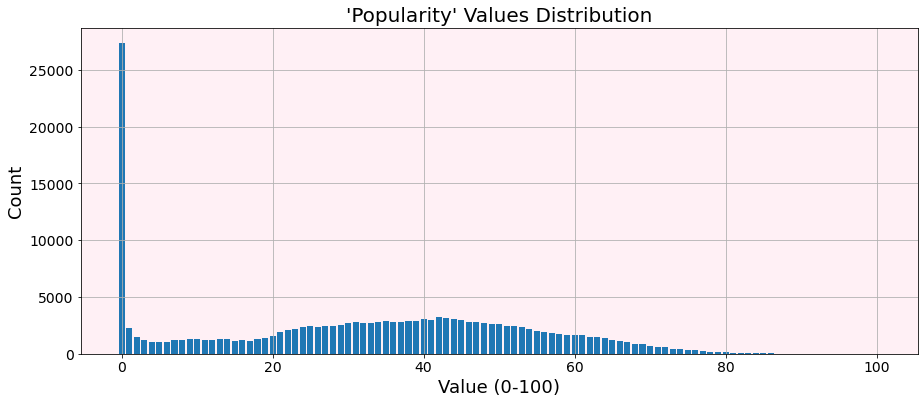

In [380]:
# Displaying the distribution
plt.figure(figsize = (15, 6))

plt.bar(pplr_dist.index, pplr_dist['count'])

plt.xlabel('Value (0-100)', size = 18)
plt.ylabel('Count', size = 18)

plt.xticks(size = 14)
plt.yticks(size = 14)

plt.title("'Popularity' Values Distribution", size = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
We can see the vast majority of songs have a popularity value = 0.<br>
These are the "long tail" of Spotify. Let's take them out to get a better view of songs that has popularity value of at least 1.
</p>

In [381]:
pplr_dist_higher_than_0 = pplr_dist[pplr_dist.index >0]
pplr_dist_higher_than_0.head()

,count
popularity,
1.0,2254
2.0,1449
3.0,1200
4.0,1074
5.0,1019


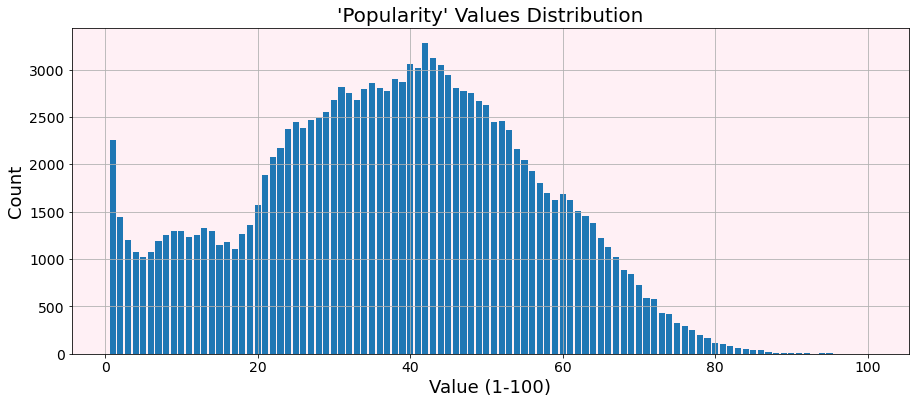

In [382]:
# And re-run the distribution
plt.figure(figsize = (15, 6))

plt.bar(pplr_dist_higher_than_0.index, pplr_dist_higher_than_0['count'])

plt.xlabel('Value (1-100)', size = 18)
plt.ylabel('Count', size = 18)

plt.xticks(size = 14)
plt.yticks(size = 14)

plt.title("'Popularity' Values Distribution", size = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
Not quite a bell curve, is it? More like a "It's Lonely at the Top" curve, which is what we could expect - It is no secret that out of hundreds of thousands of songs being published every year, only very few become hits.<br>
For our purposes, we will examine songs with popularity rating of 80 or higher, which are less than 0.5% of all the songs.<br>
That is why we will compare it with the general (all songs) tempo curve.
</p>

In [383]:
# Calculating percentage of songs with popularity >= 80.
top_20_mask = pplr_dist.index >= 80
pplr_dist['count'][top_20_mask].sum() / pplr_dist['count'].sum() *100

0.33665079542578674

In [384]:
# Creating a dataframe to hold all songs with popularity >= 80
top_0_5_mask = spt['popularity'] >= 80
top_0_5_prcnt = spt[top_0_5_mask][['year', 'tempo']]
top_0_5_prcnt.head()

,year,tempo
7957,2019,176
8033,2019,94
8058,2020,88
8099,2020,185
24159,2020,91


In [385]:
# Grouping the above dataframe to see avg tempo for each year
top_0_5_prcnt_grp = top_0_5_prcnt.groupby('year')['tempo'].mean()\
                    .to_frame()\
                    .rename(columns = {'tempo' : 'avg_tempo'})
top_0_5_prcnt_grp.head()

,avg_tempo
year,
1967,140.0
1969,130.5
1971,145.0
1972,136.0
1974,97.0


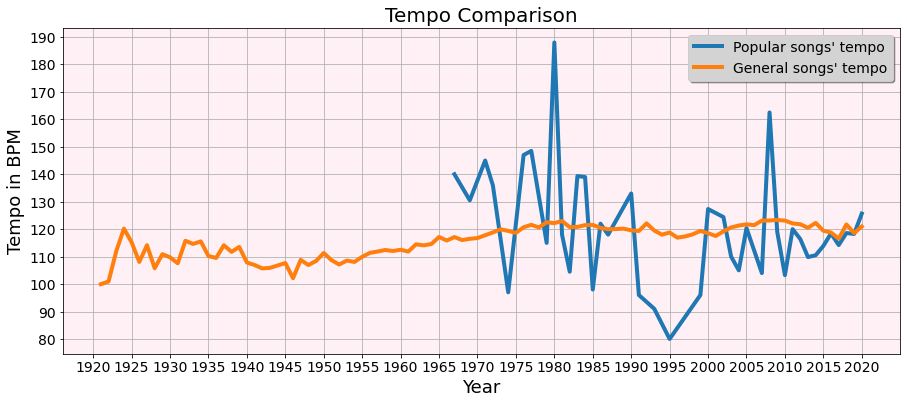

In [386]:
plt.figure(figsize = (15,6))

plt.plot(top_0_5_prcnt_grp.index, top_0_5_prcnt_grp['avg_tempo'], linewidth = 4, label = "Popular songs' tempo")
plt.plot(bpm_by_year.index, bpm_by_year['avg_tempo'], linewidth = 4, label = "General songs' tempo")

plt.xlabel('Year', size = 18)
plt.ylabel('Tempo in BPM', size = 18)

min_yr = bpm_by_year.index.min()
max_yr = bpm_by_year.index.max()
plt.xticks(range(min_yr-1, max_yr+5)[::5] , fontsize = 14)

min_y = int( np.round( top_0_5_prcnt_grp['avg_tempo'].min() ) )
max_y = int( np.round( top_0_5_prcnt_grp['avg_tempo'].max() ) )+10
plt.yticks(range(min_y, max_y)[::10], fontsize = 14)

plt.title('Tempo Comparison', size = 20)
plt.grid()
plt.legend(fontsize = 14, shadow = 4, facecolor='lightgrey')
plt.show()

<p style = "font-size:20px ; line-height: 2">
There are two main conclusions we can draw from this plot:<br>
1. Older songs are less popular than new songs - we don't even see songs from before the mid 60's making it into the popular (80 and above) curve.<br>
This is actually a phenomenon we’ve already encountered while examining the 'year' / 'popularity' correlation.
.<br>
2. While average tempo of songs in general is usually between 100-120 BPM, hit songs vary from 80 - 190 BPM - this actually corresponds with the insignificant correlation (0.14) we've seen between tempo and popularity in the Heat Map.
</p>

### e. speechiness - explicit correlation

<p style = "font-size:20px ; line-height: 2">
We could already see using the Heat Map, that the correlation (0.41) between the two features is not too high, although it is not a very low one either.<br>
But is it indeed such a medial correlation?<br>
Perhaps when compared with other correlations we can find out it actually stands out?<br>
Let's see its position amongst all correlation.
</p>

In [387]:
# Inserting all correlationsinto a dictionary
all_corr = {}

for row in spt_corr.index:
    for col in spt_corr.columns:
        all_corr[(row, col)] =  spt_corr[row][col]
        
# Removing duplicates.
# A reminder - this is our swap function: swap = lambda k: (k[1], k[0])
for k in all_corr.copy():
    all_corr[swap(k)] = all_corr.pop(k)
        
#show the first 5 elements of "all_corr", just to see that it works 
dict(it.islice(all_corr.items(), 5))



{('year', 'year'): 1.0,
 ('year', 'duration'): 0.07629109884733215,
 ('duration', 'duration'): 1.0,
 ('year', 'loudness'): 0.4901178469782819,
 ('duration', 'loudness'): -0.014683291056925233}

In [388]:
# Turning "all_corr" dictionary into a DataFrame
all_corr_df = pd.DataFrame.from_dict(all_corr, orient='index', columns = ['correlation'])

all_corr_df.reset_index(inplace = True)
all_corr_df.rename(columns = {'index' : 'features'}, inplace = True)

# Converting the tuple values in the "features" column into a string
all_corr_df['features'] = all_corr_df['features'].map('-'.join)

# showing all correlations as absolute
all_corr_df['correlation'] = abs(all_corr_df['correlation'])
all_corr_df = all_corr_df.sort_values('correlation', ascending = False)
all_corr_df.head()

,features,correlation
0,year-year,1.0
14,popularity-popularity,1.0
104,key-key,1.0
90,explicit-explicit,1.0
77,valence-valence,1.0


In [389]:
# In addition to all the correlations, we also want to display the average and the median
avg_corr = [all_corr_df['correlation'].mean()] * len(all_corr_df['features'])
avg_median = [all_corr_df['correlation'].median()] * len(all_corr_df['features'])

# In order to bring out the "speechiness-explicit" correlation, we need to find its position
spc_exp_pos = list(all_corr_df['features']).index('speechiness-explicit')

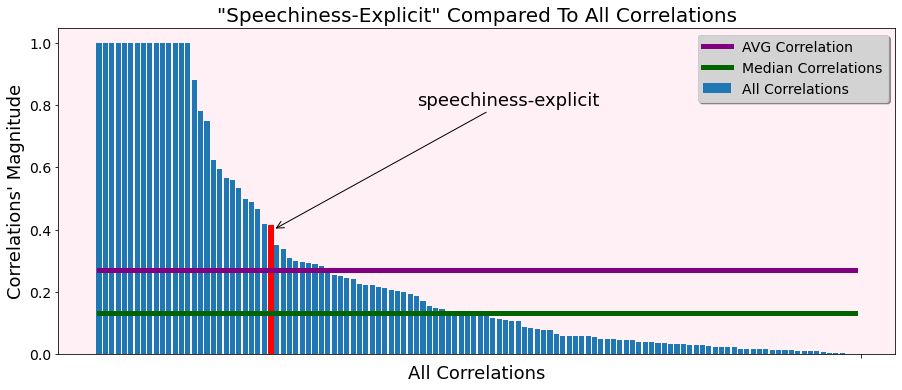

In [390]:
plt.figure(figsize = (15, 6))

plt.bar(all_corr_df['features'], all_corr_df['correlation'], label = 'All Correlations')\
    [spc_exp_pos].set_color('r')
plt.plot(all_corr_df['features'], avg_corr, linewidth = 5, label = 'AVG Correlation', color = 'purple')
plt.plot(all_corr_df['features'], avg_median, linewidth = 5, label = 'Median Correlations', color = 'darkgreen')

plt.xticks('' , fontsize = 10, rotation = 60)
plt.yticks(None, fontsize = 14)

plt.xlabel('All Correlations', fontsize = 18)
plt.ylabel("Correlations' Magnitude", fontsize = 18)

plt.annotate('speechiness-explicit', xy=(27.5, 0.4), arrowprops=dict(arrowstyle='->'), xytext=(50, 0.8), fontsize = 18)

plt.title('"Speechiness-Explicit" Compared To All Correlations', size = 20)
plt.legend(fontsize = 14, shadow = 4, facecolor='lightgrey')
plt.show()

<p style = "font-size:20px ; line-height: 2">
It seems like the speechiness - explicit correlation does stand out a little above other correlations, but that doesn’t change the fact that it is not a very strong correlation on its own right.<br>
Meaning - we cannot confidently predict that a song that has a high speechiness value will be classified as a song with explicit lyrics.
</p>

## 4. Popularity of musical keys.

<p style = "font-size:20px ; line-height: 2">
Before diving into the musical key analysis, here's a quick musical theory lesson:<br>
In western music, every scale can be played in 7 modes. In a nutshell, each mode contains the same notes of the scale, in the same order, but each mode starts with a different note.<br>
I.e. C major Consists of these notes: C, D, E, F, G, A, B (Do, Re, Mi, Fa, Sol, La, Si)<br>
The 2nd mode is called Dorian, and D dorian Consists of: D, E, F, G, A, B, C<br>
The 3rd mode is called Phrygian, and E phrygian Consists of: E, F, G, A, B, C, D<br>
And so on and so forth...<br>
The most known mode aside from the major mode, is of course the minor mode, which is the 6th mode. In our example, if we go 6 notes from C, we will get this scale: A, B, C, D, E, F, G<br>
So basically, C major is equivalent to A minor - they are different modes of the same scale.<br>
The same logic goes to G major ==> E minor, Eb major ==> C minor etc.<br>
    <br>
Now that we know that, we need to check - does the 'mode' feature in our database represents a minor scale of the 'key' feature,<br>
i.e., when key = 0 (C) and mode = 0 (minor), the musical key is C minor,<br>
or, the 'mode' feature means that the song is in the minor scale of the 'key',<br>
i.e., when key = 0 (C) and mode = 0 (minor), the musical key is A minor?
    <br>
The way to determine this, is to listen to some songs from the database and see the way they are represented in the 'key' and 'mode' columns.<br>
Here are some sample songs:<br>
- The Beatles' "When I'm Sixty Four". key = 2,  mode = 1 is played in Db major.<br>
- "Where the Wild Roses Grow" by Nick Cave and Kylie Minogue. key = 7, mode = 0 is played in G minor.<br>
- Chopin's "Waltz No.19 in A minor, Op.posth". key = 9, mode = 0 is, as the name suggests, played in A minor.<br>
- "Buddha of Suburbia" by David Bowie. key = 2, mode = 1 is played in D major.<br>
We can conclude then, that the key represents the pitch of the scale, and the mode determines whether this is a major or minor scale on that very pitch.<br>
    <br>
Naturally, in order to truly evaluate the popularity of each key, we cannot use an average function, the appropriate method would be to count how many songs were released in each key every year.<br>
It’s worth mentioning that there is an inherent inaccuracy in the database, as ‘release date’ and respectively ‘year’ do not necessarily represent the original release date of the song, but rather the release date of the specific track, i.e., “Eleanor Rigby” which was originally released in 1966, has a release date of 2014 in our database because it is from the 2014 re-release of the “Yellow Submarine” album.
</p>

In [391]:
#Creating a dataframe to hold the keys
spt_full_keys = spt[['year','key', 'mode' ]]
spt_full_keys.head()

,year,key,mode
0,1928,10,1
1,1928,8,1
2,1928,5,0
3,1928,1,0
4,1928,11,1


In [392]:
# in order to make sure each key gets its unique value, we are going to parse the key amd mode with this formula:
calc_key = lambda k,m: k-(12*(-m))

# Creating a dictionary to hold the full name of the musical key (C, Cm, Db, Dbm, etc.)
mus_key_dict = {
0 : 'C minor'
,1 : 'Db minor'
,2 : 'D minor'
,3 : 'Eb minor'
,4 : 'E minor'
,5 : 'F minor'
,6 : 'F# minor'
,7 : 'G minor'
,8 : 'Ab minor'
,9 : 'A minor'
,10 : 'Bb minor'
,11 : 'B minor'
,12 : 'C'
,13 : 'Db'
,14 : 'D'
,15 : 'Eb'
,16 : 'E'
,17 : 'F'
,18 : 'F#'
,19 : 'G'
,20 : 'Ab'
,21 : 'A'
,22 : 'Bb'
,23 : 'B'
}

In [393]:
# Creating a column to hold the full name of the musical key as a mus_key_dict[key].
spt_full_keys = spt_full_keys.assign(musical_key = calc_key(spt_full_keys['key'], spt_full_keys['mode']))

# And now we replace the musical_key column with the corresponding mus_key_dict value
spt_full_keys.replace({'musical_key' : mus_key_dict}, inplace = True)

spt_full_keys = spt_full_keys[['year','musical_key']]
spt_full_keys.head()

,year,musical_key
0,1928,Bb
1,1928,Ab
2,1928,F minor
3,1928,Db minor
4,1928,B


<p style = "font-size:20px ; line-height: 2">
Naturally, in order to truly evaluate the popularity of each key, we cannot use an average function, what we really need to do is to count how many songs were recorded in each key.<br>
</p>

In [394]:
# showing how many songs in each key are in each year
key_count = spt_full_keys.groupby(['year', 'musical_key'])['musical_key'].count()\
                .to_frame()\
                .rename(columns = {'musical_key' : 'count'})\
                .reset_index()
key_count

,year,musical_key,count
0,1921,A,9
1,1921,A minor,1
2,1921,Ab,6
3,1921,Ab minor,1
4,1921,B,3
...,...,...,...
2392,2020,F minor,74
2393,2020,F#,48
2394,2020,F# minor,73
2395,2020,G,113


In [395]:
# In order to have a better understanding, let's pivot this table
pvt_key_count = key_count.pivot_table(index = 'year'
                                     ,columns = 'musical_key'
                                     ,values = 'count')
pvt_key_count.head()

musical_key,A,A minor,Ab,Ab minor,B,B minor,Bb,Bb minor,C,C minor,...,E,E minor,Eb,Eb minor,F,F minor,F#,F# minor,G,G minor
year,,,,,,,,,,,,,,,,,,,,,
1921,9.0,1.0,6.0,1.0,3.0,5.0,5.0,3.0,11.0,3.0,...,4.0,3.0,8.0,1.0,7.0,8.0,2.0,7.0,10.0,5.0
1922,3.0,NaN,7.0,2.0,NaN,1.0,3.0,6.0,3.0,4.0,...,6.0,3.0,1.0,2.0,4.0,3.0,2.0,1.0,9.0,NaN
1923,2.0,1.0,11.0,2.0,5.0,5.0,15.0,1.0,20.0,3.0,...,7.0,5.0,15.0,3.0,19.0,3.0,4.0,5.0,12.0,4.0
1924,8.0,7.0,24.0,5.0,3.0,4.0,29.0,8.0,20.0,8.0,...,10.0,2.0,14.0,3.0,25.0,6.0,7.0,3.0,18.0,5.0
1925,4.0,10.0,19.0,2.0,9.0,1.0,17.0,8.0,22.0,8.0,...,12.0,7.0,17.0,1.0,29.0,13.0,12.0,7.0,21.0,7.0


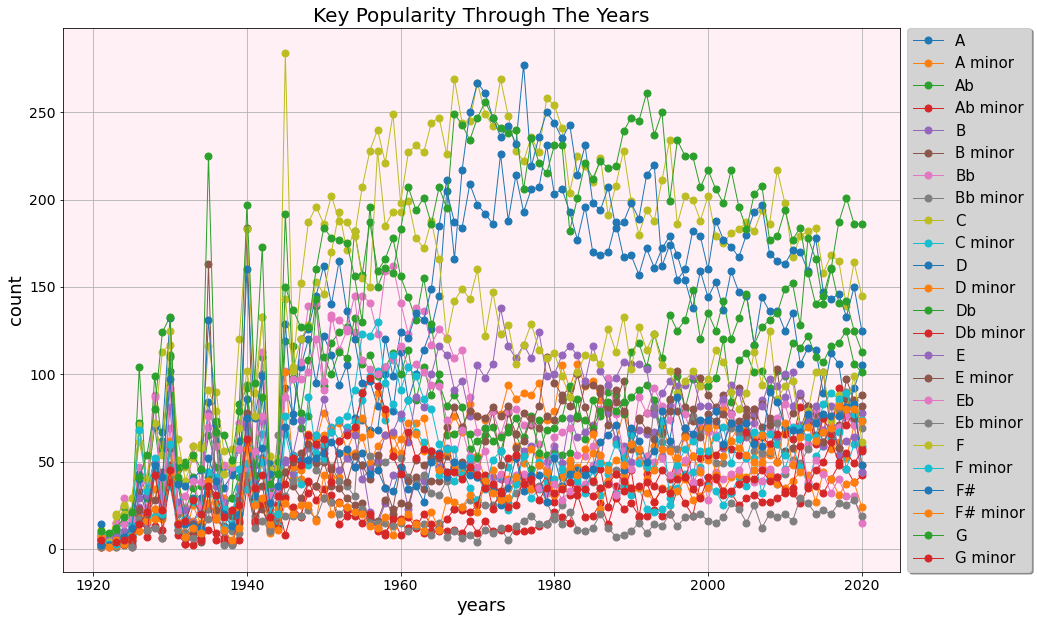

In [396]:
# Finally, let's see some plots
plt.figure(figsize = (15, 10))
plt.rcParams['axes.facecolor'] = 'lavenderblush'

for i in (pvt_key_count.columns):
    plt.plot(pvt_key_count.index, pvt_key_count[i], '-o', ms = 7, linewidth = 1, label = i)

plt.xlabel('years', fontsize = 18)
plt.ylabel('count', fontsize = 18)

plt.xticks(None, size = 14)
plt.yticks(None, size = 14)

plt.title('Key Popularity Through The Years', fontsize = 20)
plt.grid()
plt.legend(bbox_to_anchor=(1, 1.015), prop = {'size': 15}, shadow = 4, facecolor='lightgrey')
plt.show()

<p style = "font-size:20px ; line-height: 2">
It's clear to say, this is way too messy, and also not exactly what we wanted to see - we want the top key(s) for each year. 
</p>

In [397]:
# We already have the "pvt_key_count" table, let's Add a column that shows the count of the most popular key(s) for each year
pvt_key_w_max = pvt_key_count.assign(max_count  = pvt_key_count.max(axis=1))
pvt_key_w_max.reset_index(inplace = True)
pvt_key_w_max.head()

musical_key,year,A,A minor,Ab,Ab minor,B,B minor,Bb,Bb minor,C,...,E minor,Eb,Eb minor,F,F minor,F#,F# minor,G,G minor,max_count
0,1921,9.0,1.0,6.0,1.0,3.0,5.0,5.0,3.0,11.0,...,3.0,8.0,1.0,7.0,8.0,2.0,7.0,10.0,5.0,14.0
1,1922,3.0,NaN,7.0,2.0,NaN,1.0,3.0,6.0,3.0,...,3.0,1.0,2.0,4.0,3.0,2.0,1.0,9.0,NaN,9.0
2,1923,2.0,1.0,11.0,2.0,5.0,5.0,15.0,1.0,20.0,...,5.0,15.0,3.0,19.0,3.0,4.0,5.0,12.0,4.0,20.0
3,1924,8.0,7.0,24.0,5.0,3.0,4.0,29.0,8.0,20.0,...,2.0,14.0,3.0,25.0,6.0,7.0,3.0,18.0,5.0,29.0
4,1925,4.0,10.0,19.0,2.0,9.0,1.0,17.0,8.0,22.0,...,7.0,17.0,1.0,29.0,13.0,12.0,7.0,21.0,7.0,29.0


In [398]:
# Unpivoting our new table 
unpvt_key_count = pvt_key_w_max.melt(id_vars = ['year', 'max_count']
                           ,value_vars = pvt_key_count.columns[1:]
                           ,var_name = 'musical_key'
                           )\
                .sort_values('year')
unpvt_key_count.head()

,year,max_count,musical_key,value
0,1921,14.0,A minor,1.0
700,1921,14.0,C,11.0
1600,1921,14.0,Eb minor,1.0
2100,1921,14.0,G,10.0
200,1921,14.0,Ab minor,1.0


In [399]:
# Leaving only rows where the value == max_count (only the most popular key(s) for each year )
top_keys = unpvt_key_count[unpvt_key_count['max_count'] == unpvt_key_count['value']]
# And leaving only the year and key, which is the data we are actually interested in
top_keys = top_keys[['year','musical_key']]
top_keys.head()

,year,musical_key
900,1921,D
2101,1922,G
702,1923,C
503,1924,Bb
1704,1925,F


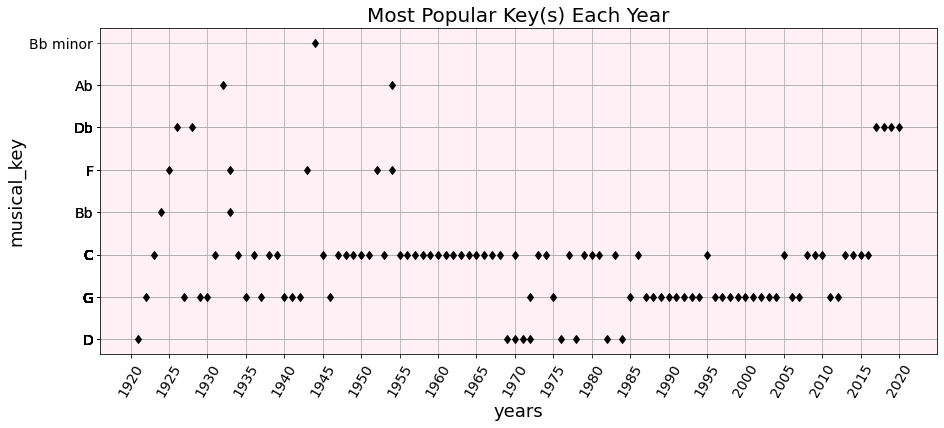

In [400]:
plt.figure(figsize = (15, 6))

plt.plot(top_keys['year'], top_keys['musical_key'], 'd', color = 'black')

plt.xlabel('years', fontsize = 18)
plt.ylabel('musical_key', fontsize = 18)

min_yr = top_keys['year'].min()
max_yr = top_keys['year'].max()
plt.xticks(range(min_yr-1, max_yr+5)[::5], size = 14, rotation = 60)
plt.yticks( top_keys['musical_key'], size = 14)

plt.title('Most Popular Key(s) Each Year', fontsize = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
There are two clear winners here!<br>
C (Major) and G (Major) are the dominating keys throughout the years.<br>
This makes sense, as both are basic keys and are easy to play on both the keyboard and the guitar.<br>
Furthermore, only 8 keys (out of 24) ever made it to be the most popular key of the year.<br>
That makes one think - what if the popularity of these keys dims other popular keys?<br>
It could be that these 8 keys just “switch places”, and on years where G is the most popular key, the 2nd most popular is C, but perhaps by looking for the 2nd most popular key of each year, we can find a little more diversity of popular keys.

</p>

In [401]:
top_keys.groupby('musical_key')['musical_key'].count()\
        .to_frame()

,musical_key
musical_key,
Ab,2
Bb,2
Bb minor,1
C,45
D,9
Db,6
F,5
G,34


In [402]:
key_count_2nd_bst = pvt_key_count.assign(pplr_2nd = pvt_key_count.loc[:, :].apply(lambda row: row.nlargest(2).values[-1],axis=1))
key_count_2nd_bst.head()

musical_key,A,A minor,Ab,Ab minor,B,B minor,Bb,Bb minor,C,C minor,...,E minor,Eb,Eb minor,F,F minor,F#,F# minor,G,G minor,pplr_2nd
year,,,,,,,,,,,,,,,,,,,,,
1921,9.0,1.0,6.0,1.0,3.0,5.0,5.0,3.0,11.0,3.0,...,3.0,8.0,1.0,7.0,8.0,2.0,7.0,10.0,5.0,11.0
1922,3.0,NaN,7.0,2.0,NaN,1.0,3.0,6.0,3.0,4.0,...,3.0,1.0,2.0,4.0,3.0,2.0,1.0,9.0,NaN,7.0
1923,2.0,1.0,11.0,2.0,5.0,5.0,15.0,1.0,20.0,3.0,...,5.0,15.0,3.0,19.0,3.0,4.0,5.0,12.0,4.0,19.0
1924,8.0,7.0,24.0,5.0,3.0,4.0,29.0,8.0,20.0,8.0,...,2.0,14.0,3.0,25.0,6.0,7.0,3.0,18.0,5.0,25.0
1925,4.0,10.0,19.0,2.0,9.0,1.0,17.0,8.0,22.0,8.0,...,7.0,17.0,1.0,29.0,13.0,12.0,7.0,21.0,7.0,22.0


In [403]:
# From now on it's more or less the same as we did before
unpvt_key_count_2nd = key_count_2nd_bst.reset_index()\
                            .melt(id_vars = ['year', 'pplr_2nd']
                           ,value_vars = pvt_key_count.columns[1:]
                           ,var_name = 'musical_key'
                           )\
                .sort_values('year')
unpvt_key_count_2nd.head()

,year,pplr_2nd,musical_key,value
0,1921,11.0,A minor,1.0
700,1921,11.0,C,11.0
1600,1921,11.0,Eb minor,1.0
2100,1921,11.0,G,10.0
200,1921,11.0,Ab minor,1.0


In [404]:
# Leaving only rows where the value == pplr_2nd (only the 2nd most popular key(s) for each year )
sec_keys = unpvt_key_count_2nd[unpvt_key_count_2nd['pplr_2nd'] == unpvt_key_count_2nd['value']]
# And leaving only the year and key, which is the data we are actually interested in
sec_keys = sec_keys[['year','musical_key']]
sec_keys.head(25)

,year,musical_key
700,1921,C
101,1922,Ab
1702,1923,F
1703,1924,F
704,1925,C
105,1926,Ab
1706,1927,F
507,1928,Bb
708,1929,C
909,1930,D


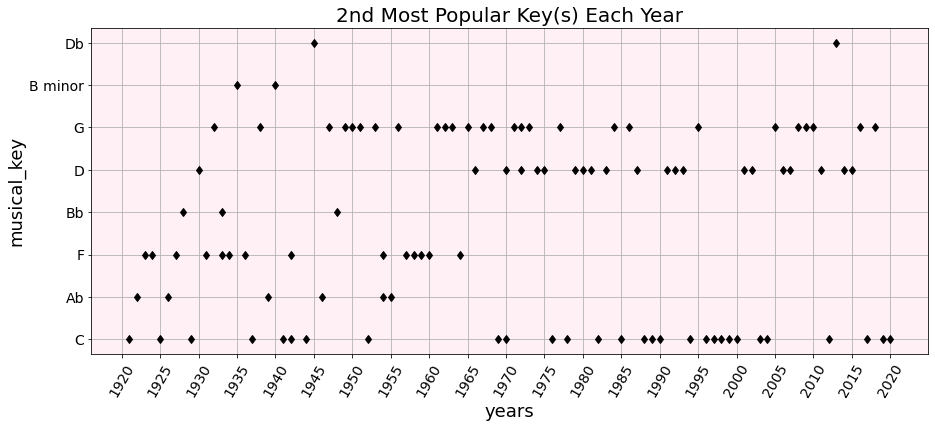

In [405]:
plt.figure(figsize = (15, 6))

plt.plot(sec_keys['year'], sec_keys['musical_key'], 'd', color = 'black')

plt.xlabel('years', fontsize = 18)
plt.ylabel('musical_key', fontsize = 18)

min_yr = sec_keys['year'].min()
max_yr = sec_keys['year'].max()
plt.xticks(range(min_yr-1, max_yr+5)[::5], size = 14, rotation = 60)

plt.yticks( sec_keys['musical_key'].drop_duplicates(), size = 14)

plt.title('2nd Most Popular Key(s) Each Year', fontsize = 20)
plt.grid()
plt.show()

<p style = "font-size:20px ; line-height: 2">
Clearly C Major and G Major are still the dominant keys, but this is a little more diverse.<br>
It is worth mentioning that F major is considered an easy key for keyboard players (only 1 "black key"), but not for guitar players, and we can see that it is quite present until 1964, but not from 1965 and on which is compatible with the establishment of Rock music as a guitar driven genre.
</p>

## 3. What makes a song popular in different decades

<p style = "font-size:20px ; line-height: 2">
To answer this question we will break down correlations between ‘popularity’ the other features in every decade.
</p>

In [406]:
# Firstly, let's create a mask for each decade
decades_masks = {'the_roaring_20s' : spt['year'].between(1920, 1929)
                ,'the_turbulent_30s' : spt['year'].between(1930, 1939)
                ,'the_fightin_40s' : spt['year'].between(1940, 1949)
                ,'the_nifty_50s' : spt['year'].between(1950, 1959)
                ,'the_swingin_60s' : spt['year'].between(1960, 1969)
                ,'the_disco_70s' : spt['year'].between(1970, 1979)
                ,'the_greedy_80s' : spt['year'].between(1980, 1989)
                ,'the_naughty_90s' : spt['year'].between(1990, 1999)
                ,'the_noughties_00s' : spt['year'].between(2000, 2009)
                ,'the_twenty_10s' : spt['year'].between(2010, 2019)
}

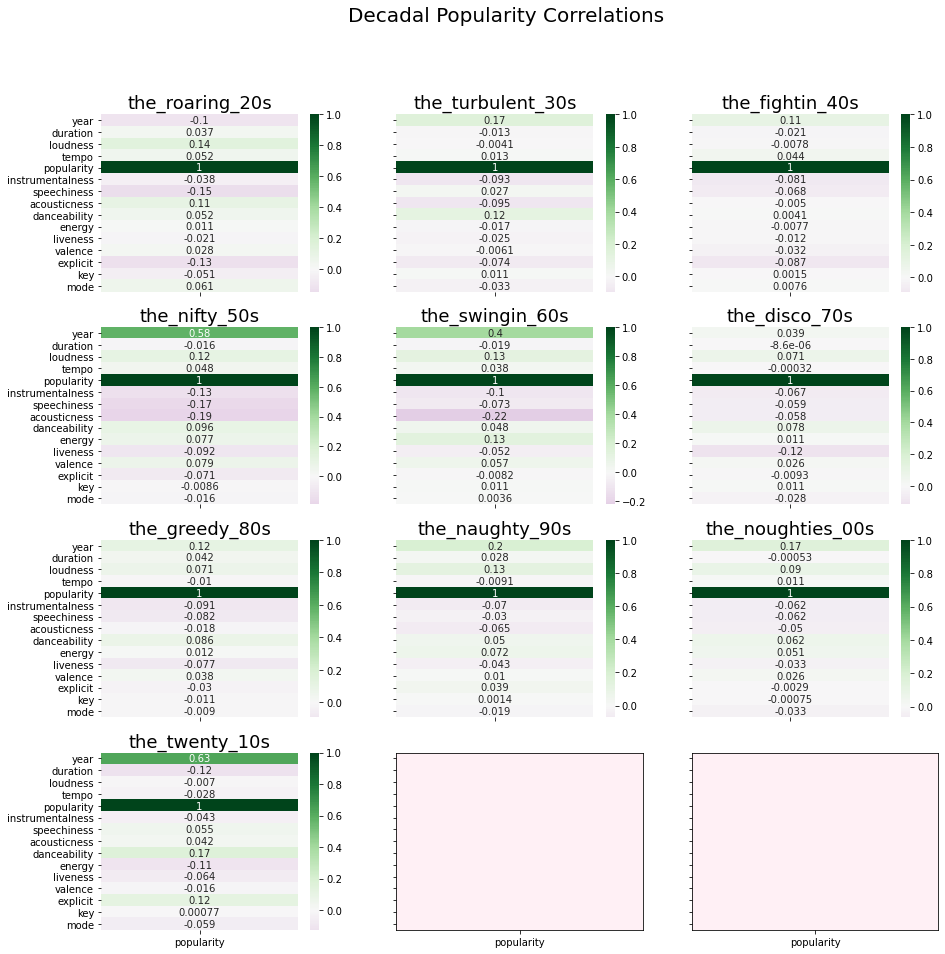

In [407]:
def popcorr(key):
    dcd = spt[decades_masks[key]]
    dcd_heat_map = sns.heatmap( dcd.corr()[['popularity']]
                                ,cmap = 'PRGn'
                                ,annot = True
                                ,cbar = True
                                ,center = 0
                                ,ax = axs[row_pos, col_pos])
    return dcd_heat_map

plt.rcParams['axes.facecolor'] = 'lavenderblush'
fig, axs = plt.subplots(4, 3,figsize=(15,15), sharex = True, sharey = True)

for k in decades_masks.keys():
    row_pos = list(decades_masks.keys()).index(k) // 3
    col_pos = list(decades_masks.keys()).index(k) % 3
    popcorr(k)
    axs[row_pos, col_pos].set_title(k, fontsize = 18)

fig.suptitle('Decadal Popularity Correlations', size = 20)
plt.show()

<p style = "font-size:20px ; line-height: 2">
Even a quick glance can reveal that there is no real correlation between popularity and any other feature (ignoring a few weak correlations with the year in some features), regardless of the decade.<br>
Pitty, but apparently it takes some other, non-measurable qualities, for a song to become a hit. 
</p>

## Summary

<p style = "font-size:20px ; line-height: 2">
Before summarizing, we should remind that this database contains only a fraction of over 60 million tracks available on Spotify (as of Oct 2020. Source: https://newsroom.spotify.com/company-info) and accordingly, all conclusions are only valid to this database, and not the whole of the Spotify tracks database.<br>
The strongest and most noticeable conclusion, is that, unfortunately, we cannot safely predict the behavior of certain features as a result of others. Out of 105 possible pairs for the 15 features we analyzed, only 8 pairs had correlation stronger than 0.5.<br>
The only parameter that does makes a difference is time - it is clear several features did change through the years.<br>
There is however one main feature that we do not have in this database in spite of its importance - the genre(s) associated with each track.<br>
When we talk about music we sometimes tend to forget that music is not of homorganic nature - each genre holds various and different characteristics.<br>
Having a genre indication for each track might have improve the prediction of correlations, as long as the correlated features are of tracks that share the same genre.
</p>